Train and compare GP regression models using each encoding for each task. 

In [1]:
import sys
import itertools
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn import model_selection

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src")

from embeddings_reproduction import gpm
from embeddings_reproduction import gpk
from embeddings_reproduction import stringkernel

In [2]:
%matplotlib inline

In [3]:
sns.set_style('white')
sns.set_context('paper')

In [4]:
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 35})
plt.rcParams.update({'legend.fontsize': 30})
plt.rcParams.update({'axes.titlesize': 16})

plt.rcParams.update({'axes.grid': False})

In [5]:
# assert np.__version__ == '1.13.1'
# assert pd.__version__ == '0.20.3'

In [6]:
def select_X_and_Y(df, all_X, y_column):
    not_dropped = ~pd.isnull(df[y_column])
    not_dropped = pd.Series(not_dropped, index=df.index)
    Ys = df[not_dropped][y_column]
    Ys.index = df[not_dropped]['name']
    Xs = all_X.loc[Ys.index]
    return Xs, Ys

def score(Y, pred_Y, pred_var):
    r1 = stats.rankdata(Y)
    r2 = stats.rankdata(pred_Y)
    scores = {}
    scores['kendalltau'] = stats.kendalltau(r1, r2).correlation
    scores['R2'] = metrics.r2_score(Y, pred_Y)
    scores['mae'] = metrics.mean_absolute_error(Y, pred_Y)
    scores['SE'] = metrics.mean_squared_error(Y, pred_Y)
    scores['R'] = np.corrcoef(Y, pred_Y)[0, 1]
    log_ps = -0.5 * np.log(pred_var) - (pred_Y - Y)**2 / 2 / pred_var
    log_ps -= 0.5 * np.log(2 * np.pi)
    scores['log_loss'] = -np.sum(log_ps)
    return scores

def evaluate(df_train, df_test, X, task, X_name, guesses=None, kernel='matern'):
    X_train, y_train = select_X_and_Y(df_train, X, task)
    X_test, y_test = select_X_and_Y(df_test, X, task)
    n_train, d = X_train.shape
    n_test, d = X_test.shape
    if kernel == 'matern':
        k = gpk.MaternKernel('5/2')
    if kernel == 'cubic':
        k = gpk.PolynomialKernel(3)
    clf = gpm.GPRegressor(k, guesses=guesses)
    clf.fit(X_train, y_train)
    print(X_name)
    print(clf.hypers)
    mu, var = clf.predict(X_test)
    met1 = score(y_test, mu, np.diag(var))
    met1['task'] = task
    met1['X'] = X_name
    met1['d'] = d
    met1['n_train'] = n_train
    met1['n_test'] = n_test
    met1['kernel'] = kernel
    met1 = pd.DataFrame(met1, index=[0])
    return met1, mu

def evaluate_mismatch(df, df_train, df_test, y_col, k, m, guesses=None):
    A = sorted(set(itertools.chain.from_iterable(df['sequence'].values)))
    ke = stringkernel.MismatchKernel(k, A, m)
    X = df[['sequence']]
    X.index = df['name']
    X_train, y_train = select_X_and_Y(df_train, X, y_col)
    X_test, y_test = select_X_and_Y(df_test, X, y_col)
    clf = gpm.GPRegressor(ke, guesses=guesses)
    clf.fit(X_train['sequence'].values, y_train)
    print(k, m)
    print(clf.hypers)
    mu, var = clf.predict(X_test['sequence'].values)
    met1 = score(y_test, mu, np.diag(var))
    met1['task'] = y_col
    met1['X'] = ''
    met1['n_train'] = len(y_train)
    met1['n_test'] = len(y_test)
    met1['kernel'] = 'mismatch_' + str(k) + '_' + str(m)
    met1 = pd.DataFrame(met1, index=[0])
    return met1, mu

def plot_results(ax, y_test, mu, title):
    _ = ax.plot(y_test, mu, 'o', alpha=0.8, ms=10)
    _ = ax.set_title(title)
    _ = ax.text(0.05, 0.9, 
                r'$\tau$ = %0.2f, MAE = %0.2f' %(evals.loc[0, 'kendalltau'], evals.loc[0, 'mae']), 
                transform=ax.transAxes, fontsize=15)

In [7]:
res = pd.DataFrame(index=[], columns=['task', 'X', 'd', 'n_train', 'n_test', 
                                      'kernel', 'R', 'R2', 'SE', 'kendalltau', 'log_loss'])

### MTS Localization

C:\Users\IGB\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\IGB\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\IGB\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

5 1
[0.16284967 0.8357062 ]


C:\Users\IGB\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



IndexError: too many indices for array

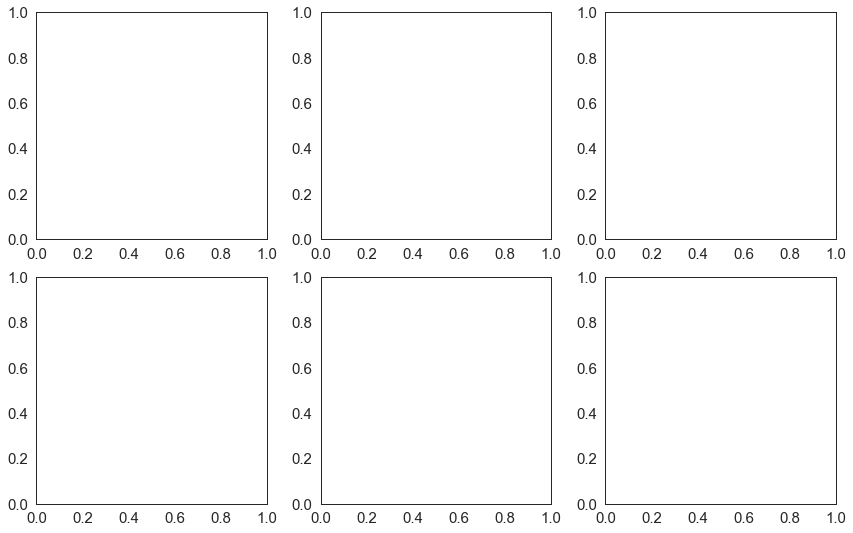

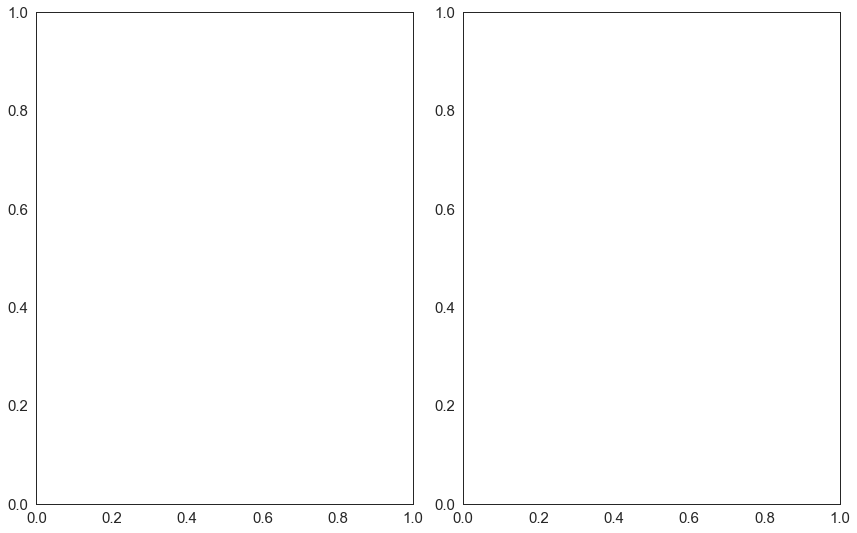

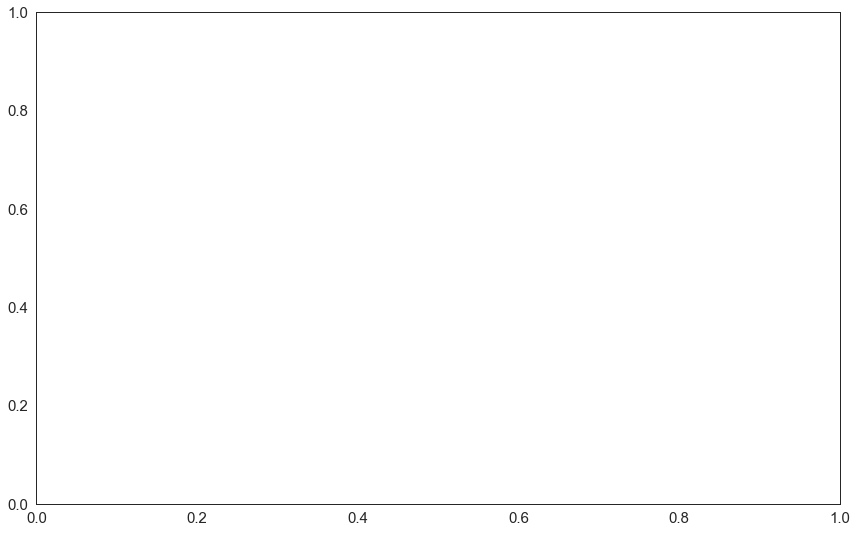

<Figure size 864x540 with 0 Axes>

<Figure size 864x540 with 0 Axes>

In [8]:
y_col = 'log_GFP'
dataset = '../inputs/MTS_localization.txt'
embedding_dirs = '../outputs/MTS_localization_embeddings/'
emb = 'X_small_2_3.pkl'
fig, axs = plt.subplots(2, 3, figsize=(12, 7.5))
fig.tight_layout()

df = pd.read_csv(dataset)
df_test = df[~df.is_train]
df_train = df[df.is_train]
y_test = df_test.dropna(subset=[y_col])[y_col]

df_test['is_train'] = [False for _ in range(len(df_test))]
df_train['is_train'] = [True for _ in range(len(df_train))]


y_col = 'log_GFP'
dataset = '../inputs/MTS_localization.txt'
embedding_dirs = '../outputs/MTS_localization_embeddings/'
emb = 'X_small_3_3.pkl'
fig, axs = plt.subplots(1, 2, figsize=(12, 7.5))
fig.tight_layout()

df = pd.read_csv(dataset)
df_test = df[~df.is_train]
df_train = df[df.is_train]
y_test = df_test.dropna(subset=[y_col])[y_col]

df_test['is_train'] = [False for _ in range(len(df_test))]
df_train['is_train'] = [True for _ in range(len(df_train))]

y_col = 'log_GFP'
dataset = '../inputs/MTS_localization.txt'
embedding_dirs = '../outputs/MTS_localization_embeddings/'
emb = 'X_small_4_3.pkl'
fig, axs = plt.subplots(1, 1, figsize=(12, 7.5))
fig.tight_layout()

df = pd.read_csv(dataset)
df_test = df[~df.is_train]
df_train = df[df.is_train]
y_test = df_test.dropna(subset=[y_col])[y_col]

df_test['is_train'] = [False for _ in range(len(df_test))]
df_train['is_train'] = [True for _ in range(len(df_train))]


y_col = 'log_GFP'
dataset = '../inputs/MTS_localization.txt'
embedding_dirs = '../outputs/MTS_localization_embeddings/'
emb = 'X_small_5_7.pkl'
fig, axs = plt.subplots(0, 2, figsize=(12, 7.5))
fig.tight_layout()

df = pd.read_csv(dataset)
df_test = df[~df.is_train]
df_train = df[df.is_train]
y_test = df_test.dropna(subset=[y_col])[y_col]

df_test['is_train'] = [False for _ in range(len(df_test))]
df_train['is_train'] = [True for _ in range(len(df_train))]

y_col = 'log_GFP'
dataset = '../inputs/MTS_localization.txt'
embedding_dirs = '../outputs/MTS_localization_embeddings/'
emb = 'X_small_3_5.pkl'
fig, axs = plt.subplots(1, 0, figsize=(12, 7.5))
fig.tight_layout()

df = pd.read_csv(dataset)
df_test = df[~df.is_train]
df_train = df[df.is_train]
y_test = df_test.dropna(subset=[y_col])[y_col]

df_test['is_train'] = [False for _ in range(len(df_test))]
df_train['is_train'] = [True for _ in range(len(df_train))]


# Mismatch Kernel
evals, mu = evaluate_mismatch(df, df_train, df_test, y_col, 5, 1)
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[0, 1], y_test, mu, 'mismatch kernel: k=5, m=1')


# Embedding
with open(embedding_dirs + emb, 'rb')  as f:
    X, _ = pickle.load(f)
%time evals, mu = evaluate(df_train, df_test, X, y_col, emb[:-4], guesses=(0.1, 10))
res = pd.concat((res, evals), ignore_index=True)
plot_results(axs[0, 0], y_test, mu, 'embedding')

for i in range(2):
    for j in range(3):
        y0 = -9.2
        y1 = -4
        axs[i, j].set_ylim([y0, y1])
        x0, x1 = axs[i, j].get_xlim()
        _ = axs[i, j].plot([y0, x1], [y0, x1], '--', color='grey', alpha=0.6)
        if i != 1:
            axs[i, j].get_xaxis().set_visible(False)
        if j != 0:
            axs[i, j].get_yaxis().set_visible(False)
_ = fig.text(0.5, 0.0, 'measured localization', ha='center', va='center', fontsize=16)
_ = fig.text(0.0, 0.5, 'predicted localization', ha='center', va='center', rotation=90, fontsize=16)

In [ ]:
res[res['task'] == 'log_GFP']